In [ ]:
## @EricWalzthoeny.

In [ ]:
!pip3 install -qq datasets[vision]

     |████████████████████████████████| 325 kB 12.2 MB/s 
     |████████████████████████████████| 212 kB 55.5 MB/s 
     |████████████████████████████████| 136 kB 53.1 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 127 kB 49.9 MB/s 
     |████████████████████████████████| 144 kB 33.3 MB/s 
     |████████████████████████████████| 271 kB 38.8 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip3 install -qq transformers

     |████████████████████████████████| 4.0 MB 10.3 MB/s 
     |████████████████████████████████| 895 kB 38.8 MB/s 
     |████████████████████████████████| 6.6 MB 51.0 MB/s 
     |████████████████████████████████| 596 kB 42.4 MB/s 


In [ ]:
########## OS & Files ##########
import os 
import glob
########## linalg & data handling ##########
import pandas as pd
import numpy as np 
########## plotting 
import matplotlib.pyplot as plt
########## NNS
import torch
import transformers
from datasets import load_dataset, DatasetDict,load_metric

In [ ]:
## current directory 
CURR_DIR = "/content/drive/MyDrive/HackUPC"
## ZIP FILE DATA 
ZIP_DATA = "Natrural_human_face.zip"
## Unzipped file location 
DATA = "/content/drive/MyDrive/HackUPC/data/Natrural_human_face"
## output folder 
OUT = "data"
## output for the transformer 
TRANSFORMER = "/content/drive/MyDrive/HackUPC/data/emotions_out"
## DATASET CHECKPOINT 
DATA_CHKPT = "/content/drive/MyDrive/HackUPC/saved_dataset"
## joining the paths 
ZIP_DIR = os.path.join(CURR_DIR, ZIP_DATA)
OUT_DIR = os.path.join(CURR_DIR, OUT)
DATA_DIR = os.path.join(CURR_DIR, DATA)
## Transformer out folder 
T_OUT = os.path.join(CURR_DIR, TRANSFORMER)
## CHECKPOINT 
DS_CHECK = os.path.join(CURR_DIR, DATA_CHKPT)

In [ ]:
def unzip_file(in_path:str, out_path:str) -> None:
  ## unzip the file 
  import zipfile
  if os.path.isdir(out_path):
    print("The folder already exists.")
  else:
    with zipfile.ZipFile(in_path, 'r') as zip_ref:
        zip_ref.extractall(out_path)
## running it 
unzip_file(ZIP_DIR, OUT_DIR)

The folder already exists.


The number of emotions are 8


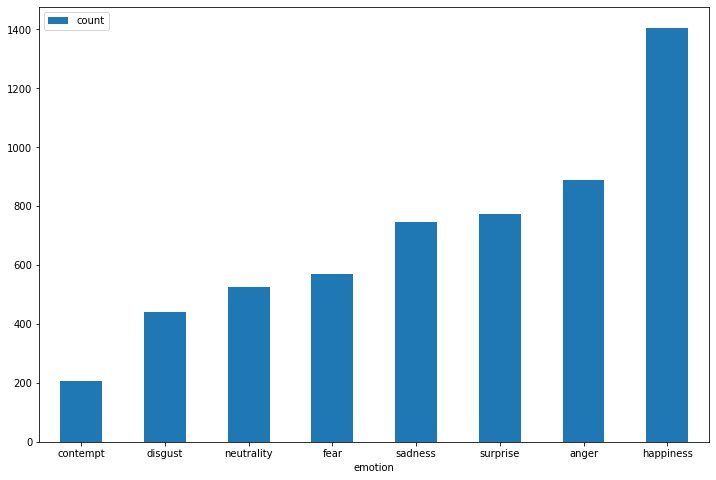

In [ ]:
## look at the folders 
folders = glob.glob(DATA_DIR+"/*") ## 8 emotions 
emotion_names = [x.split("/")[-1] for x in folders]
print(f"The number of emotions are {len(emotion_names)}")
## some information about the class
instances_per_class = [len(glob.glob(folders[i]+"/*.png")) for i in range(len(emotion_names))]
## join the classes with the names 
data_info = dict(zip(emotion_names, instances_per_class))
## visualizing the dataframe
df = pd.DataFrame.from_records(data_info,index=[0]).T
df = df.reset_index()
df.columns = ['emotion','count']
df.sort_values(by="count", ascending=True).set_index("emotion").plot(kind='bar', rot=0, figsize=(12,8));plt.show()

In [ ]:
## get the labels with an index 
label2idx = dict(zip(emotion_names,range(len(emotion_names))))
idx2label = dict(zip(range(len(emotion_names)), emotion_names))
## create a dataframe with the label and their paths 
all_files = glob.glob(DATA_DIR+"/*/*.png")
emotions = [x.split("/")[-2] for x in all_files]
df = pd.DataFrame(columns=['files','emotion'])
df['files'] = all_files 
df['emotion'] = emotions
df['emotion'] = df['emotion'].map(label2idx)
df.to_csv(CURR_DIR+"/img_dataset.csv")

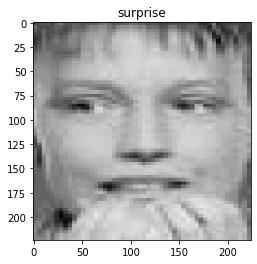

In [ ]:
## visualize one image
from PIL import Image
## get an image and read it 
seed = np.random.seed(42)
sample = np.random.choice(df['files'])
img = Image.open(sample).convert('RGB')
## get the corresponding emotion 
corr_label = df[df.loc[:,'files'] == sample]['emotion'].values[0]
plt.imshow(img,cmap='gray')
plt.title(idx2label[corr_label])
plt.show()

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
## define the feature extractor
MODEL_NAME = 'google/vit-base-patch16-224'
fe = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
## load the dataset
#dataset = load_dataset("imagefolder",data_dir=DATA_DIR)
#dataset.save_to_disk(CURR_DIR + "/saved_dataset")
import datasets
dataset = datasets.load_from_disk(DS_CHECK)

In [ ]:
## process the dataset in a format that HF understands 
def process_data(data):
  """
  Processes the data and performs the appropriate feature extraction.
  """
  inputs = fe([x.convert("RGB") for x in data['image']], return_tensors='pt')
  inputs['labels'] = data['label']
  return inputs

## apply the processing to the data 
prepared_ds = dataset.with_transform(process_data)

## split the data into train, test, validation 
# 90% train, 10% test + validation
train_test = prepared_ds['train'].train_test_split(test_size=0.1)
# Split the 10% test + valid in half test, half valid
# gather everyone if you want to have a single DatasetDict
train_test_split = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test'],
    })

Loading cached split indices for dataset at /content/drive/MyDrive/HackUPC/saved_dataset/train/cache-bc560d57cdb4aa48.arrow and /content/drive/MyDrive/HackUPC/saved_dataset/train/cache-ad3cf57dfa7219a7.arrow


In [ ]:
labels = train_test_split['train'].features['label'].names

In [ ]:
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=idx2label,
    label2id=label2idx,
    ignore_mismatched_sizes=True
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6b03b61d64598274e01717c40e8909f9e70531219a281e8163bd5b3af5c92d1a.c41e6c561c79e9b15e74a5cc284a31cba59cb1a9e209933c1a04a46ba2e20e44
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "contempt",
    "1": "fear",
    "2": "surprise",
    "3": "sadness",
    "4": "neutrality",
    "5": "happiness",
    "6": "anger",
    "7": "disgust"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 6,
    "contempt": 0,
    "disgust": 7,
    "fear": 1,
    "happiness": 5,
    "neutrality": 4,
    "sadness": 3,
    "surprise": 2
  },
  "layer_norm_ep

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=T_OUT,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_split["train"],
    eval_dataset=train_test_split["test"],
    tokenizer=fe,
)

Using amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5002
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1252


Step,Training Loss,Validation Loss,Accuracy
100,1.512900,1.478018,0.456835
200,1.358000,1.358330,0.482014
300,1.305900,1.225005,0.543165
400,0.988300,1.206097,0.553957
500,1.120900,1.149506,0.546763
600,0.979300,1.178733,0.570144
700,0.490600,1.254028,0.604317
800,0.434200,1.380242,0.582734
900,0.469600,1.310440,0.604317
1000,0.132000,1.479951,0.607914


***** Running Evaluation *****
  Num examples = 556
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-100
Configuration saved in /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-100/config.json
Model weights saved in /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-100/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 556
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-200
Configuration saved in /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-200/config.json
Model weights saved in /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-200/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/HackUPC/data/emotions_out/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num exa

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1444055797GF
  train_loss               =       0.7469
  train_runtime            =   1:27:02.53
  train_samples_per_second =        3.831
  train_steps_per_second   =         0.24


In [ ]:
metrics = trainer.evaluate(train_test_split['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 556
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.5468
  eval_loss               =     1.1495
  eval_runtime            = 0:00:29.75
  eval_samples_per_second =     18.686
  eval_steps_per_second   =      2.353


## Sklearn

In [ ]:
DATA = "/content/drive/MyDrive/HackUPC/data/icml_face_data.csv"

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv(DATA,low_memory=False)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
data['emotion_txt'] = df['emotion'].map(emotion_dict)
## getting the numpy array from the text
data.columns = ['target','split','pixels','emotion_text']
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=" "))
data.drop("split",axis=1, inplace=True)

In [ ]:
data.head(1)

,target,pixels,emotion_text
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Angry


In [ ]:
## separate the data into X & Y 
X = data.drop(['target', 'emotion_text'], axis=1).values
y = data['target'].values
## sepparate into training and testing 
from sklearn.model_selection import train_test_split
## splitting 
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.1)

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 5.7 MB/s 


In [ ]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}

clf = GridSearchCV(MLkNN(), parameters, scoring='f1_macro')
clf.fit(x_train, y_train)